In [24]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

In [25]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("Device:", device, "| GPUs:", n_gpu)

torch.manual_seed(42)

Device: cuda | GPUs: 2


In [ ]:
# Config
EPOCHS = 4
BATCH_SIZE = 16
LR = 3e-5
MAX_LEN = 384
PATH_DATASET = "/kaggle/input/arabic-qa-cleaned/data_cleaned.csv"
MODEL_CHECKPOINT = "aubmindlab/bert-base-arabertv2"

In [27]:
# Load dataset
df = pd.read_csv(PATH_DATASET).dropna()
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(len(train_df), len(val_df), len(test_df))

154768 19346 19346


In [28]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [29]:
# Encoding
def encode_example(row):
    q, c, a = str(row["question"]), str(row["context"]), str(row["answer"])
    start_char = c.find(a)
    if start_char == -1:
        return None

    enc = tokenizer(
        q, c,
        truncation="only_second",
        max_length=MAX_LEN,
        padding="max_length",
        return_offsets_mapping=True
    )

    start_tok, end_tok = None, None
    for i, (s, e) in enumerate(enc["offset_mapping"]):
        if s <= start_char < e:
            start_tok = i
        if s < start_char + len(a) <= e:
            end_tok = i

    if start_tok is None or end_tok is None:
        return None

    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
        "start_positions": start_tok,
        "end_positions": end_tok
    }

def encode_df(df):
    data = []
    for r in df.to_dict("records"):
        e = encode_example(r)
        if e:
            data.append(e)
    return data

train_data = encode_df(train_df)
val_data   = encode_df(val_df)

print("Encoded:", len(train_data), len(val_data))

Encoded: 116279 14436


In [30]:
# Dataset
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {k: torch.tensor(v) for k, v in self.data[idx].items()}

train_ds = QADataset(train_data)
val_ds   = QADataset(val_data)

In [31]:
# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE * max(1, n_gpu),
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE * max(1, n_gpu),
    num_workers=2,
    pin_memory=True
)

In [32]:
# Model
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_CHECKPOINT)

if n_gpu > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForQuestionAnswering(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(64000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [33]:
# Optimizer + Scheduler
optimizer = AdamW(model.parameters(), lr=LR * max(1, n_gpu))
steps = EPOCHS * len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, steps)

scaler = GradScaler()

/tmp/ipykernel_55/2436954047.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [34]:
# Training + Validation
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    total_train_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")
    for batch in loop:
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}

        with autocast():
            outputs = model(**batch)
            loss = outputs.loss.mean()   # 🔴 FIX (scalar)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss.mean()
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

Epoch 1 [Train]:   0%|          | 0/3634 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

Epoch 1 | Train: 1.4041 | Val: 1.1837


Epoch 2 [Train]:   0%|          | 0/3634 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

Epoch 2 | Train: 1.0382 | Val: 1.1214


Epoch 3 [Train]:   0%|          | 0/3634 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

Epoch 3 | Train: 0.7965 | Val: 1.1856


Epoch 4 [Train]:   0%|          | 0/3634 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZER

Epoch 4 | Train: 0.5946 | Val: 1.3193


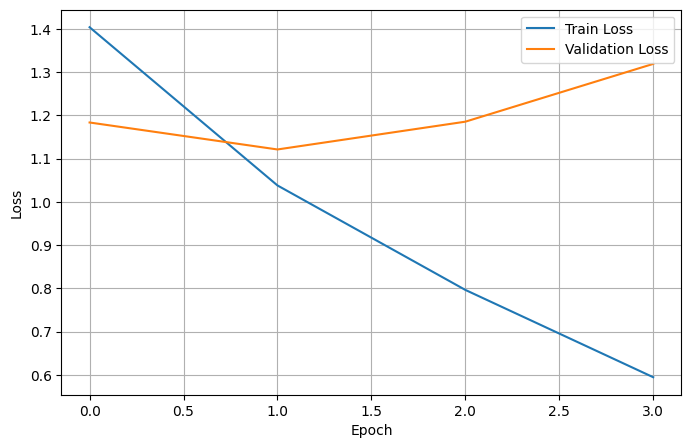

In [35]:
# Plot losses
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [39]:
# %% [code]
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer_base = AutoTokenizer.from_pretrained(
    MODELS_CONFIG["AraBERTv2-base"]["checkpoint"],
    use_fast=True
)
def compute_em_f1(preds, labels):
    em, f1 = 0, 0
    for p, l in zip(preds, labels):
        em += int(p == l)

        p_tokens = p.split()
        l_tokens = l.split()
        common = Counter(p_tokens) & Counter(l_tokens)
        num_same = sum(common.values())

        if num_same == 0:
            continue

        precision = num_same / len(p_tokens)
        recall = num_same / len(l_tokens)
        f1 += 2 * precision * recall / (precision + recall)

    n = len(preds)
    return em / n, f1 / n


model.eval()
val_losses = []
pred_texts, gold_texts = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validating"):
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            start_positions=batch["start_positions"],
            end_positions=batch["end_positions"]
        )

        # 🔧 FIX: loss is a tensor → take mean
        val_losses.append(outputs.loss.mean().item())

        start_preds = torch.argmax(outputs.start_logits, dim=1)
        end_preds   = torch.argmax(outputs.end_logits, dim=1)

        for i in range(len(start_preds)):
            ids = batch["input_ids"][i]

            pred_ans = tokenizer_base.decode(
                ids[start_preds[i]: end_preds[i] + 1],
                skip_special_tokens=True
            )

            gold_ans = tokenizer_base.decode(
                ids[
                    batch["start_positions"][i]:
                    batch["end_positions"][i] + 1
                ],
                skip_special_tokens=True
            )

            pred_texts.append(pred_ans.strip())
            gold_texts.append(gold_ans.strip())

val_em, val_f1 = compute_em_f1(pred_texts, gold_texts)

print(f"Validation Loss: {np.mean(val_losses):.4f}")
print(f"Validation EM:   {val_em:.4f}")
print(f"Validation F1:   {val_f1:.4f}")


Validating: 100%|██████████| 452/452 [03:25<00:00,  2.20it/s]

Validation Loss: 1.3193
Validation EM:   0.6822
Validation F1:   0.7633


In [36]:
# Save model
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained("./arabic_qa_model")
tokenizer.save_pretrained("./arabic_qa_model")

('./arabic_qa_model/tokenizer_config.json',
 './arabic_qa_model/special_tokens_map.json',
 './arabic_qa_model/vocab.txt',
 './arabic_qa_model/added_tokens.json',
 './arabic_qa_model/tokenizer.json')

In [41]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model and tokenizer
checkpoint = "./arabic_qa_model"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)
model.to(device)
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [44]:
def answer_question(question, context, tokenizer, model):
    inputs = tokenizer(question, context, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    start_idx = torch.argmax(outputs.start_logits, dim=1).item()
    end_idx = torch.argmax(outputs.end_logits, dim=1).item()
    
    answer_tokens = inputs["input_ids"][0][start_idx:end_idx+1]
    answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
    return answer


context = "تونس هي دولة تقع في شمال إفريقيا وتعتبر أصغر دولة من حيث المساحة في شمال إفريقيا."
question = "أين تقع تونس؟"


predicted_answer = answer_question(question, context, tokenizer, model)
print("Question:", question)
print("Answer:", predicted_answer)


Question: أين تقع تونس؟
Answer: في شمال إفريقيا
